In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
from utils import load_json_file, read_fasta_data, get_recovery_percentage, get_aligned_identity
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from aligned_clustering import conduct_align_clustering
import random
import numpy as np
from nltk import edit_distance

In [3]:
# Loading the recoveries object
recoveries = load_json_file(json_filepath=r"C:\Users\Parv\Doc\RA\Projects\incomplete_cycles\v2\raptor_data\recoveries_93cc38f3-720a-40b6-b644-8b600178a6d7.json")

In [4]:
# Loading the original strands
original_strands = read_fasta_data(fasta_filepath=r"C:\Users\Parv\Doc\RA\Projects\incomplete_cycles\v2\raptor_data\cat.jpg_RU10.fasta")[0]
original_strand_length = len(original_strands[0])

In [5]:
candidates = list(set(recoveries['candidates']))

# In the first step, we are selecting the candidates that are of the right length
candidates_of_strand_length = [candidate for candidate in candidates if len(candidate) ==  original_strand_length]

In [72]:


def get_best_candidates_and_recoveries(original_strands, candidates):
    """
    For a given set of strands, finds the best candidates and returns a dictionary with
    the recoveries, the number of fully recovered strands, the best set of candidates and the
    original strands
    """
    
    fully_recovered_strands = 0
    recoveries = []
    partially_recovered_recoveries = []
    best_candidates = []

    for strand in original_strands:
        if strand in candidates:
            fully_recovered_strands += 1
            recoveries.append(1.0)
            best_candidates.append(strand)
        else:
            best_recovery_within_candidates = 0.0
            best_candidate = ""
            for candidate in candidates:
                strand_recovery = get_recovery_percentage(
                    consensus_strand=candidate, original_strand=strand)

                if strand_recovery > best_recovery_within_candidates:
                    best_recovery_within_candidates = strand_recovery
                    best_candidate = candidate

            recoveries.append(best_recovery_within_candidates)
            partially_recovered_recoveries.append(best_recovery_within_candidates)
            best_candidates.append(best_candidate)

    return {
        "recoveries": recoveries,
        "fully_recovered_strands": fully_recovered_strands,
        "partially_recovered_recoveries": partially_recovered_recoveries,
        "best_candidates": best_candidates,
        "original_strands": original_strands
    }


In [91]:
best_candidate_dict = get_best_candidates_and_recoveries(original_strands=list(set(candidates_of_strand_length)), candidates=original_strands)

100%|██████████| 2957/2957 [00:20<00:00, 144.85it/s]


(array([1615.,   35.,   27.,   20.,   18.,   39.,   26.,   33.,   18.,
         396.]),
 array([0.328125  , 0.39479167, 0.46145833, 0.528125  , 0.59479167,
        0.66145833, 0.728125  , 0.79479167, 0.86145833, 0.928125  ,
        0.99479167]),
 <BarContainer object of 10 artists>)

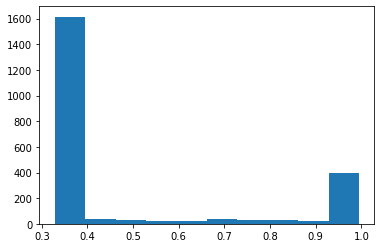

In [93]:
plt.hist(best_candidate_dict['partially_recovered_recoveries'])

In [113]:
len(candidates_of_strand_length)

2957

In [115]:
recoveries_dict = get_best_candidates_and_recoveries(original_strands, candidates_of_strand_length)

100%|██████████| 770/770 [00:01<00:00, 537.05it/s] 


In [21]:

grouped_candidates_by_strand = [[] for i in range(len(original_strands))]
garbage_strands = []

for candidate in tqdm(candidates_of_strand_length):
    if candidate in original_strands:
        grouped_candidates_by_strand[original_strands.index(candidate)].append(candidate)
    else:
        found_flag = False
        for index, strand in enumerate(original_strands):
            
            recovery = get_recovery_percentage(candidate, strand)

            if recovery > 0.8:
                grouped_candidates_by_strand[index].append(candidate)
                found_flag = True
                break
        
        if not found_flag:
            garbage_strands.append(candidate)


  0%|          | 0/2957 [00:00<?, ?it/s]

In [84]:
candidate_groups = {}
nbeg = 3

for candidate in candidates_of_strand_length:
    if candidate[:nbeg] in candidate_groups:
        candidate_groups[candidate[:nbeg]].append(candidate)
    else:
        candidate_groups[candidate[:nbeg]] = [candidate]

In [85]:
candidate_groups_ = candidate_groups.values()

In [86]:
group_sizes = [len(i) for i in candidate_groups_]
matched_groups = []

for group in candidate_groups_:
    for candidate in group:
        if candidate in original_strands:
            matched_groups.append(len(group))
            break